In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, BatchNormalization
from keras.callbacks import TensorBoard

from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
df_data = pd.read_csv('data.csv')
print(df_data.shape)

(55277, 2)


In [3]:
df_data.head(10)

,Time,Lux
0,2018-08-10 09:41:37 UTC,527
1,2018-08-10 09:42:26 UTC,942
2,2018-08-10 09:43:16 UTC,942
3,2018-08-10 09:44:04 UTC,942
4,2018-08-10 09:44:53 UTC,942
5,2018-08-10 09:45:41 UTC,941
6,2018-08-10 09:46:31 UTC,951
7,2018-08-10 09:47:19 UTC,951
8,2018-08-10 09:48:08 UTC,951
9,2018-08-10 09:48:57 UTC,951


In [4]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55277 entries, 0 to 55276
Data columns (total 2 columns):
Time    55277 non-null object
Lux     55277 non-null int64
dtypes: int64(1), object(1)
memory usage: 863.8+ KB


In [5]:
df_data['Time'] = pd.to_datetime(df_data['Time'])

In [6]:
hour, minute, second = [], [], []
for i in range(np.size(df_data, 0)):
    hour.append(df_data['Time'][i].hour)
    minute.append(df_data['Time'][i].minute)
    second.append(df_data['Time'][i].second)

In [7]:
hour = np.array(hour).reshape(-1, 1)
minute = np.array(minute).reshape(-1, 1)
second = np.array(second).reshape(-1, 1)

print(hour.shape, minute.shape, second.shape)

(55277, 1) (55277, 1) (55277, 1)


In [8]:
lux = df_data['Lux'].values.reshape(-1, 1)
print(lux.shape)

(55277, 1)


In [9]:
data = np.concatenate((hour, minute, second, lux), axis=1)
print(data.shape)

(55277, 4)


In [10]:
data[:10]

array([[  9,  41,  37, 527],
       [  9,  42,  26, 942],
       [  9,  43,  16, 942],
       [  9,  44,   4, 942],
       [  9,  44,  53, 942],
       [  9,  45,  41, 941],
       [  9,  46,  31, 951],
       [  9,  47,  19, 951],
       [  9,  48,   8, 951],
       [  9,  48,  57, 951]], dtype=int64)

In [11]:
train_data = data[:40000]
train_lux = lux[:40000]
print(train_data.shape, train_lux.shape)

(40000, 4) (40000, 1)


In [12]:
test_data = data[40001:]
test_lux = lux[40001:]
print(test_data.shape, test_lux.shape)

(15276, 4) (15276, 1)


In [14]:
lag=15 # 몇분 후 의 데이터를 input feature로 할지(?)

In [15]:
arr = []
for i in range(15):
    arr.append(train_data[i:i-lag,:])

arr = np.array(arr, dtype=np.float32)
print(arr.shape)

(15, 39985, 4)


In [16]:
arr[:15,:10,:4]

array([[[  9.,  41.,  37., 527.],
        [  9.,  42.,  26., 942.],
        [  9.,  43.,  16., 942.],
        [  9.,  44.,   4., 942.],
        [  9.,  44.,  53., 942.],
        [  9.,  45.,  41., 941.],
        [  9.,  46.,  31., 951.],
        [  9.,  47.,  19., 951.],
        [  9.,  48.,   8., 951.],
        [  9.,  48.,  57., 951.]],

       [[  9.,  42.,  26., 942.],
        [  9.,  43.,  16., 942.],
        [  9.,  44.,   4., 942.],
        [  9.,  44.,  53., 942.],
        [  9.,  45.,  41., 941.],
        [  9.,  46.,  31., 951.],
        [  9.,  47.,  19., 951.],
        [  9.,  48.,   8., 951.],
        [  9.,  48.,  57., 951.],
        [  9.,  49.,  46., 951.]],

       [[  9.,  43.,  16., 942.],
        [  9.,  44.,   4., 942.],
        [  9.,  44.,  53., 942.],
        [  9.,  45.,  41., 941.],
        [  9.,  46.,  31., 951.],
        [  9.,  47.,  19., 951.],
        [  9.,  48.,   8., 951.],
        [  9.,  48.,  57., 951.],
        [  9.,  49.,  46., 951.],
        [ 

In [17]:
x_train_val = np.concatenate((arr[0], arr[1], arr[2], arr[3], arr[4], arr[5], arr[6], arr[7], arr[8], arr[9], arr[10], arr[11], arr[12], arr[13], arr[14]), axis=1).reshape(-1, 15, 4)
train_mean, train_std = np.mean(x_train_val, axis=0), np.std(x_train_val, axis=0)
train_mean, train_std = np.mean(train_mean, axis=0), np.mean(train_std, axis=0)

In [18]:
y_train_val = train_lux[lag:, :].reshape(-1, 1)

In [19]:
print(x_train_val.shape, y_train_val.shape)

(39985, 15, 4) (39985, 1)


In [20]:
arr = []
for i in range(15):
    arr.append(test_data[i:i-lag,:])
    
arr = np.array(arr, dtype=np.float32)
print(arr.shape)


(15, 15261, 4)


In [21]:
x_test = np.concatenate((arr[0], arr[1], arr[2], arr[3], arr[4], arr[5], arr[6], arr[7], arr[8], arr[9], arr[10], arr[11], arr[12], arr[13], arr[14]), axis=1).reshape(-1, 15, 4)
y_test = test_lux[lag:, :].reshape(-1, 1)
print(x_test.shape, y_test.shape)

(15261, 15, 4) (15261, 1)


In [22]:
# split into training and validation datasets
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.2)
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(31988, 15, 4) (31988, 1) (7997, 15, 4) (7997, 1)


In [23]:
h_units = 64
activation_ = 'relu'

def rnn_model():
    model = Sequential()
    
    model.add(LSTM(units=h_units, return_sequences=False, input_shape=(15, 4)))        
    model.add(Dense(64))
    
    model.add(Dense(1))
    
    return model

In [24]:
# create a model 
model = rnn_model()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                17664     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 21,889
Trainable params: 21,889
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [26]:
# training
tensorBoard = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=False)

hist = model.fit(x_train, y_train, epochs=100, batch_size=2048, verbose=True, validation_data=(x_val, y_val), shuffle=True, callbacks=[tensorBoard])

Instructions for updating:
Use tf.cast instead.
Train on 31988 samples, validate on 7997 samples
Epoch 1/100
31988/31988 [==============================] - 1s 42us/step - loss: 804669.3064 - val_loss: 803676.1036
Epoch 2/100
31988/31988 [==============================] - 0s 14us/step - loss: 797489.3863 - val_loss: 795738.7083
Epoch 3/100
31988/31988 [==============================] - 0s 15us/step - loss: 788144.8662 - val_loss: 784227.2064
Epoch 4/100
31988/31988 [==============================] - 0s 15us/step - loss: 775670.2113 - val_loss: 771025.5208
Epoch 5/100
31988/31988 [==============================] - 0s 15us/step - loss: 761492.0615 - val_loss: 755474.2888
Epoch 6/100
31988/31988 [==============================] - 0s 15us/step - loss: 744730.1855 - val_loss: 737207.6110
Epoch 7/100
31988/31988 [==============================] - 0s 15us/step - loss: 725249.9634 - val_loss: 716199.4593
Epoch 8/100
31988/31988 [==============================] - 0s 15us/step - loss: 703068.9431

In [27]:
y_pred = model.predict(x_test, batch_size=1024, verbose=True) 
print(y_pred.shape)
print(model.evaluate(x_test, y_test,batch_size=1024))

15261/15261 [==============================] - 0s 18us/step
(15261, 1)
15261/15261 [==============================] - 0s 13us/step
6860.5098974459


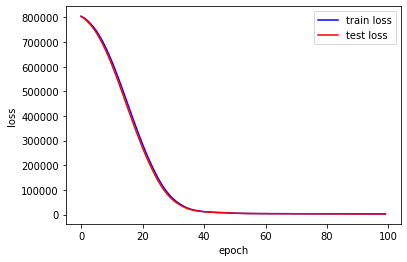

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

loss_ax.plot(hist.history['loss'], 'b', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='test loss')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

loss_ax.legend(loc='upper right')

plt.show()

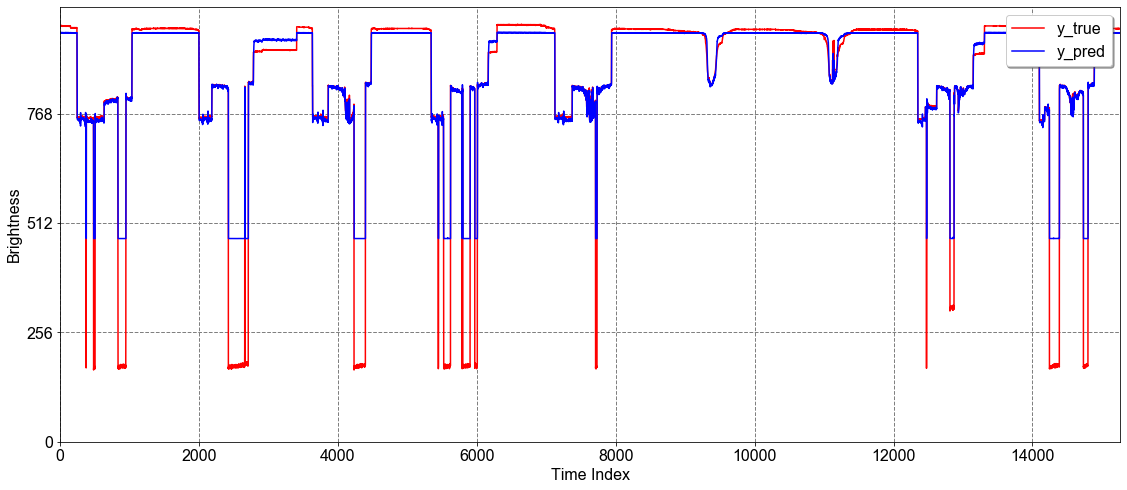

In [29]:
# visualization for prediction result
# set figure size
plt.figure(figsize=(19,8))

# set font
font = {'family': 'Arial', 'weight': 'normal', 'size': 16}
plt.rc('font', **font)

# plot data 
plt.plot(y_test[:,0], 'r', label='y_true')
plt.plot(y_pred[:,0], 'b', label='y_pred')

# set legend position
plt.legend(shadow=True, loc='upper right')

# set x-axis & y-axis titles
#plt.title('prediction result')
plt.xlabel('Time Index')
plt.ylabel('Brightness')

# set axis-limits
plt.xlim(left = 0, right = len(y_test)) 
plt.ylim(bottom = 0.3) 

# set grid
plt.grid(color='gray', linestyle='--', linewidth=1)

plt.xticks(np.arange(0,16000,2000))
plt.yticks(np.arange(0,1024,256))

# save & display figure
plt.show()

In [30]:
#모델 평가하기
trainScore = model.evaluate(x_train, y_train, verbose=0)
print('Train Score: ', trainScore)
#valScore = model.evaluate(x_val, y_val, verbose=0)
#print('Validataion Score: ', valScore)
testScore = model.evaluate(x_test, y_test, verbose=0)
print('Test Score: ', testScore)

Train Score:  2576.5677699625335
Test Score:  6860.509887706873


In [31]:
#MAPE

y_test, y_pred = np.array(y_test), np.array(y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print('MAPE: ', mape)

MAPE:  13.160012959285558


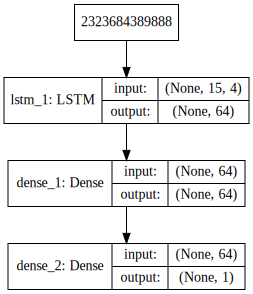

In [32]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))